In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
import mmcv
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(mmcv.__version__)
print(get_compiling_cuda_version())
print(get_compiler_version())

# Check mmocr installation
import mmocr
print(mmocr.__version__)

%cd /home/cvk/mmocr/
!ls

1.7.0+cu110 True
2.18.0
1.3.17
11.0
GCC 7.3
0.3.0
/home/cvk/mmocr
CITATION.cff		       LICENSE		 setup.py
configs			       MANIFEST.in	 test1.csv
data			       mmocr		 test.csv
demo			       mmocr_demo.ipynb  test.png
docker			       model-index.yml	 tests
docs			       outputs		 tools
docs_zh_CN		       README.md	 Untitled1.ipynb
Final_round_mmocr-Copy1.ipynb  README_zh-CN.md	 Untitled.ipynb
Final_round_mmocr-Copy2.ipynb  requirements	 wget-log
Final_round_mmocr-Copy3.ipynb  requirements.txt  wildreceipt.tar
Final_round_mmocr.ipynb        resources
INFO			       setup.cfg


In [75]:
#parameters
lineFactor = 0.8

In [127]:
from mmocr.utils.ocr import MMOCR
import pytesseract
import cv2

img = 'demo/img/demo7.png'


mmocr = MMOCR(det='PS_CTW',kie = 'SDMGR')
mmocr.readtext(img, print_result = False, output='demo/out004.png')
a = mmocr.readtext(img, details=True)

results = []
image = cv2.imread(img)

for element in a[0]['result']:
    x = 0
    y = 0
    xs = []
    ys = []
    for idx, i in enumerate(element['box']):
        if idx % 2 == 0:
            xs.append(i)
            x += i
        else:
            ys.append(i)
            y += i
            
    x = round(x / (len(element['box'])/2))
    y = round(y / (len(element['box'])/2))
    
    crop = image[min(ys):max(ys), min(xs):max(xs)]
    config = ("-l eng --oem 3 --psm 13")
    text = pytesseract.image_to_string(crop, config=config)

    results.append({
        'x': x,
        'y': y,
        'text': text.replace('|',''),
        'xmin':min(xs),
        'xmax':max(xs),
        'ymin':min(ys),
        'ymax':max(ys),
        
    })



load checkpoint from http path: https://download.openmmlab.com/mmocr/textdet/psenet/psenet_r50_fpnf_600e_ctw1500_20210401-216fed50.pth


/home/cvk/mmocr/mmocr/apis/inference.py:48: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


load checkpoint from http path: https://download.openmmlab.com/mmocr/textrecog/seg/seg_r31_1by16_fpnocr_academic-72235b11.pth
load checkpoint from http path: https://download.openmmlab.com/mmocr/kie/sdmgr/sdmgr_unet16_60e_wildreceipt_20210520-7489e6de.pth


/home/cvk/.local/lib/python3.8/site-packages/mmdet/datasets/utils.py:65: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
/home/cvk/mmocr/mmocr/datasets/kie_dataset.py:43: UserWarning: KIEDataset is only initialized as a downstream demo task of text detection and recognition without an annotation file.
  warnings.warn(
/home/cvk/.local/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
/home/cvk/mmocr/mmocr/datasets/pipelines/box_utils.py:46: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, us

<IPython.core.display.Javascript object>


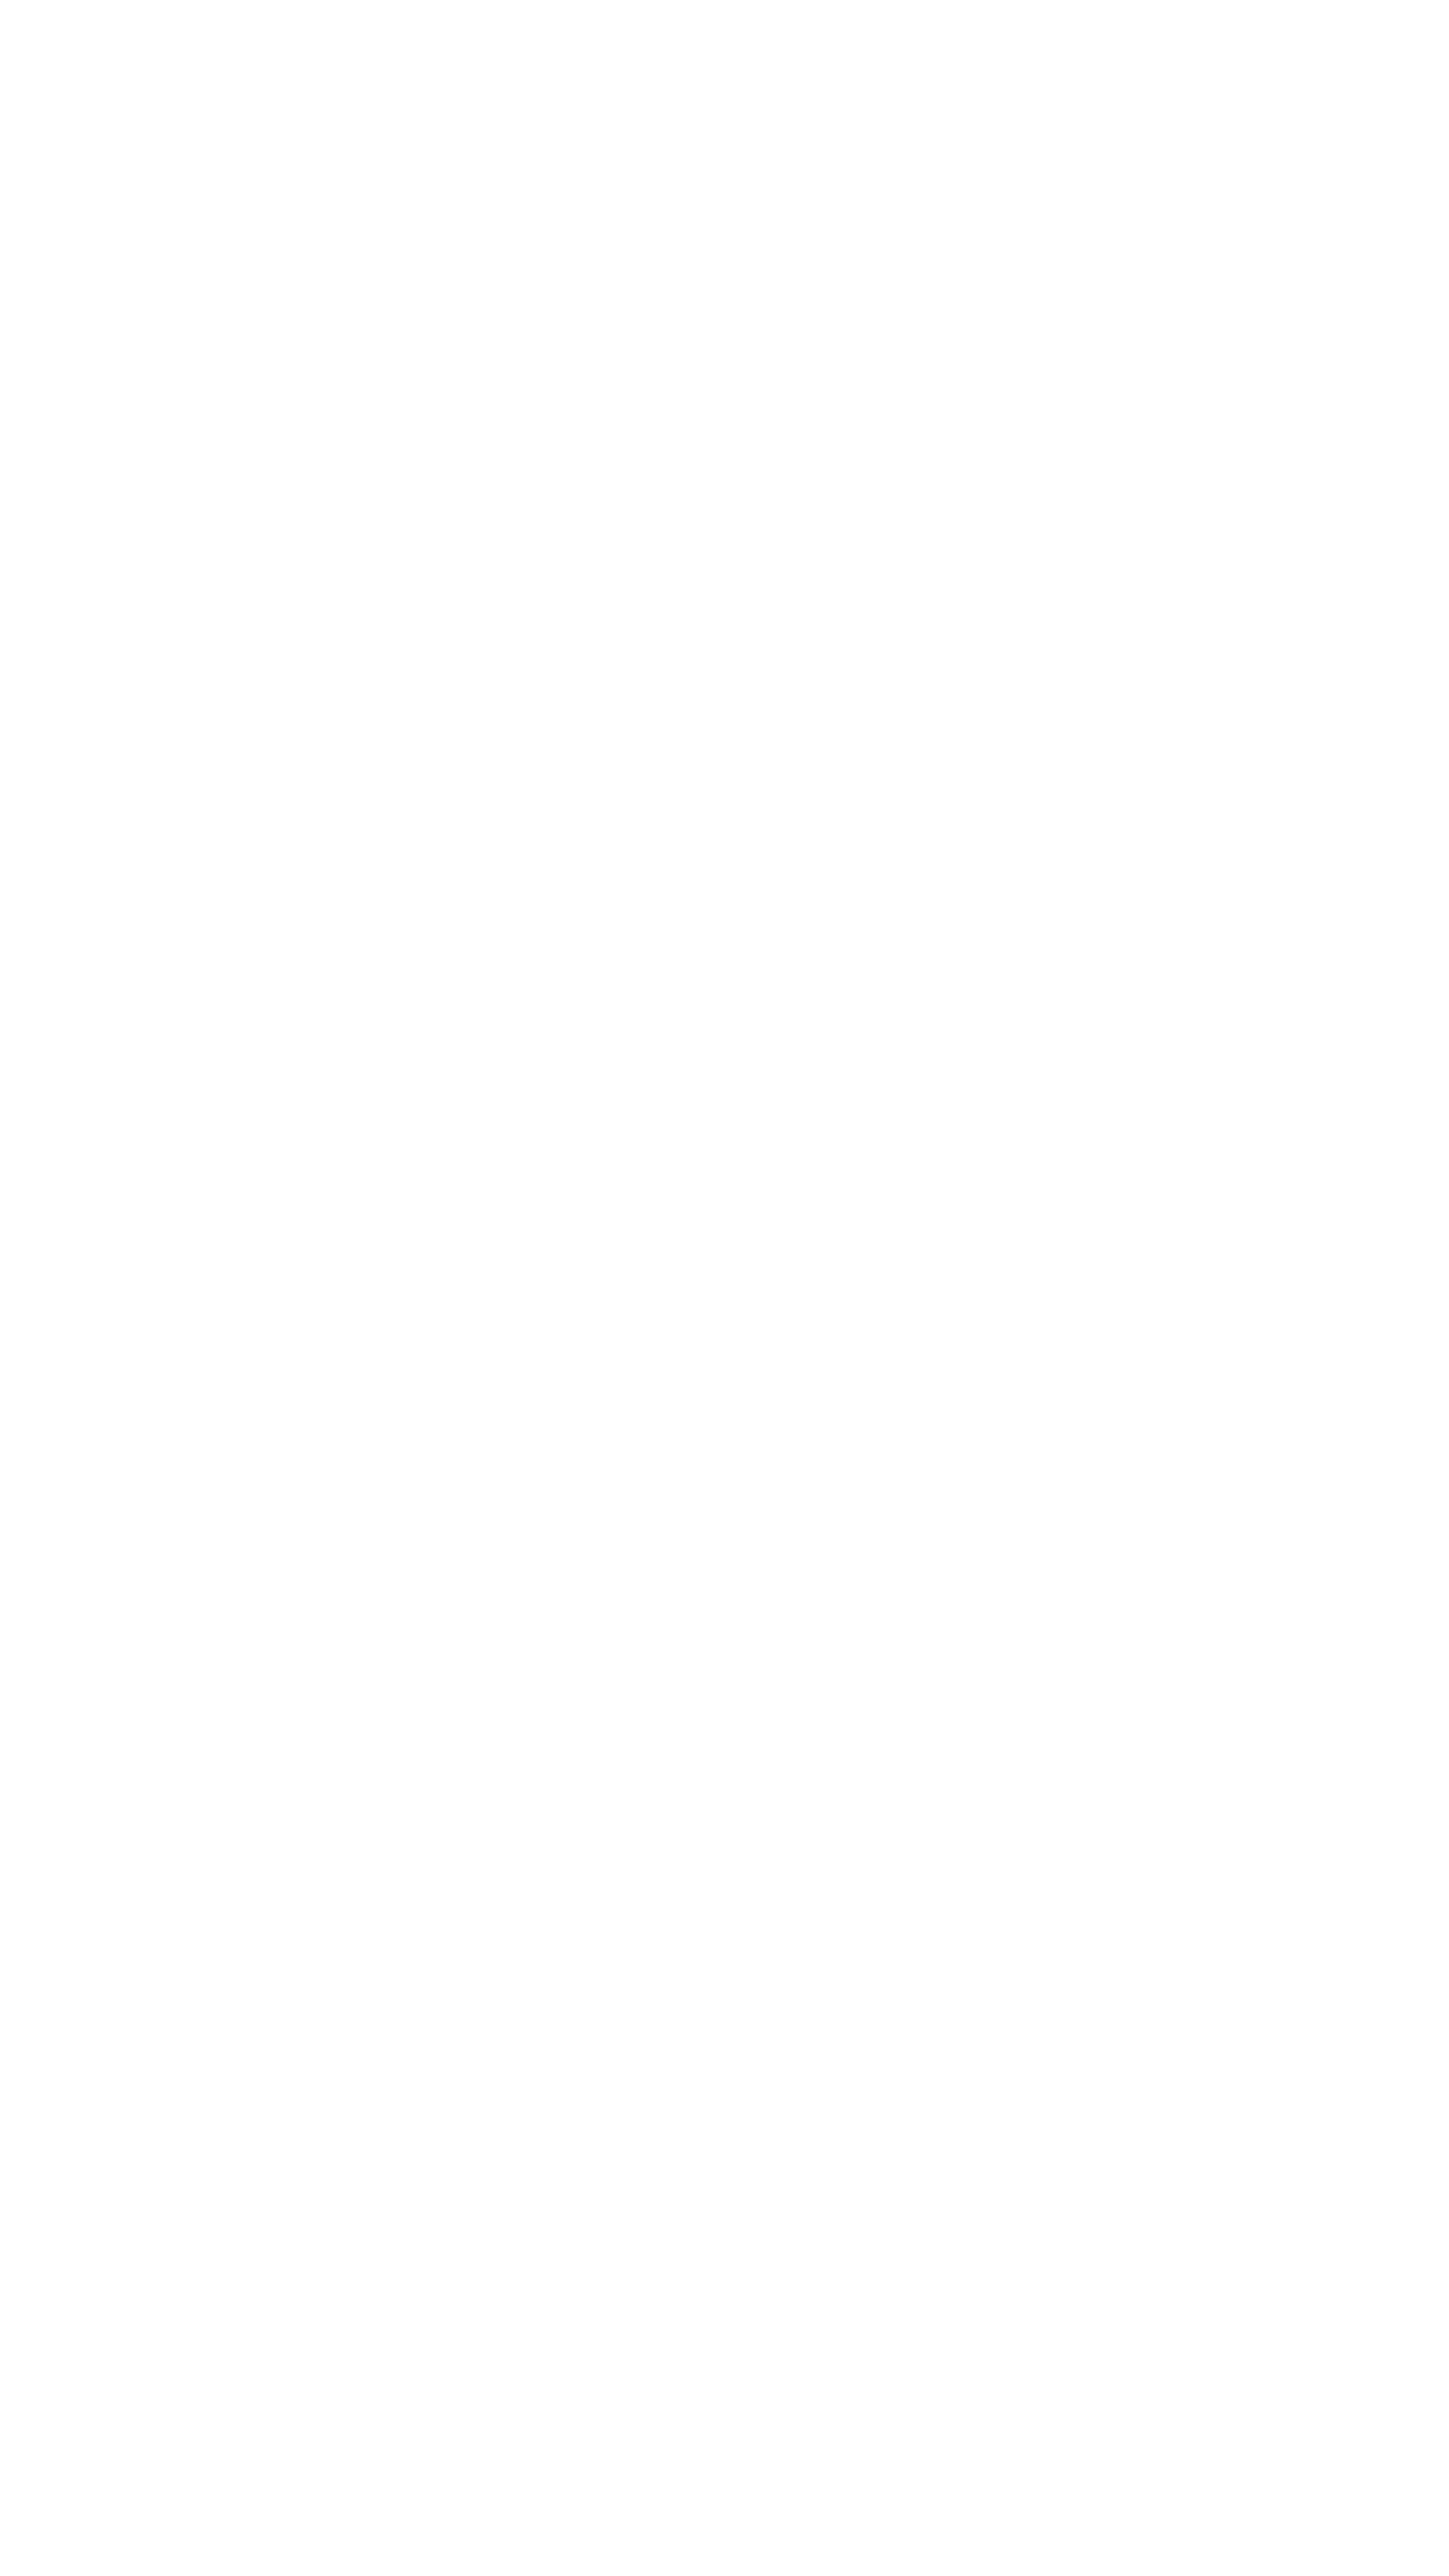

In [128]:
# Visualize the results
import matplotlib.pyplot as plt
predicted_img = mmcv.imread('demo/out004.png')
plt.figure(figsize=(18, 32))
plt.imshow(mmcv.bgr2rgb(predicted_img))
plt.show()

<IPython.core.display.Javascript object>


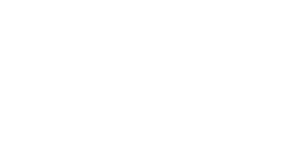

In [129]:
from sklearn.cluster import KMeans
import numpy as np
import math
import itertools

from matplotlib import pyplot as plt
%matplotlib notebook

X = np.array([[x['x']] for x in results])
ax = []
ay = []

overlapList = []
ax = []

for c in range(2, len(results)//2):
    kmeans = KMeans(n_clusters=c, random_state=42).fit(X)
    centers = [i[0] for i in kmeans.cluster_centers_]
    
    labels = kmeans.labels_
    
    overlap = 0
    
    #Find overlaping element in clusters based on xmin and xmax
    for idx, i in enumerate(centers):
        for jdx, j in enumerate(results):
            if labels[jdx] != idx:
                if i >= j['xmin'] and i <= j['xmax']:
                    overlap += 1
        
    overlapList.append(overlap)
    ax.append(c)


    
    
    
ax = np.array(ax)
ay = np.array(overlapList)

plt.plot(ax, ay)

In [130]:
def getError(reg, x, y):
    x = [i[0] for i in x]
    y = [i[0] for i in y]
    a = reg.coef_
    b = reg.intercept_
    rv = 0
    for idx, i in enumerate(x):
        rv += (a*i + b - y[idx])**2
    return rv    

In [131]:
from sklearn.linear_model import LinearRegression
X = [[n] for n in range(len(ay))]
y = [[n] for n in ay]
maxScore = 0
xClusters = 0

for n in range(2, len(ay)-2):
    X1 = X[:n]
    y1 = y[:n]
    X2 = X[n:]
    y2 = X[n:]
    reg1 = LinearRegression().fit(X1, y1)
    reg2 = LinearRegression().fit(X2, y2)
    res = getError(reg1, X1, y1)[0][0] + getError(reg2, X2, y2)[0][0]
    if res > 10:
        xClusters = n-1
        break
        
print(xClusters)

8


<IPython.core.display.Javascript object>


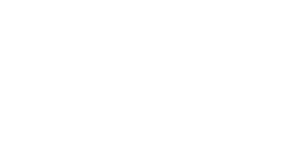

In [132]:
%matplotlib notebook

from sklearn.cluster import KMeans
import numpy as np
import math
import itertools

from matplotlib import pyplot as plt
%matplotlib notebook

X = np.array([[y['y']] for y in results])
ax = []
ay = []

overlapList = []
ax = []

for c in range(2, len(results)//2):
    kmeans = KMeans(n_clusters=c, random_state=42).fit(X)
    centers = [i[0] for i in kmeans.cluster_centers_]
    
    labels = kmeans.labels_
    
    overlap = 0
    
    #Find overlaping element in clusters based on ymin and ymax
    for idx, i in enumerate(centers):
        for jdx, j in enumerate(results):
            if labels[jdx] != idx:
                if i >= j['ymin'] and i <= j['ymax']:
                    overlap += 1
        
    overlapList.append(overlap)
    ax.append(c)
    
    
ax = np.array(ax)
ay = np.array(overlapList)

plt.plot(ax, ay)

In [133]:
from sklearn.linear_model import LinearRegression
X = [[n] for n in range(len(ay))]
y = [[n] for n in ay]
maxScore = 0
yClusters = 0
for n in range(2, len(ay)-2):
    X1 = X[:n]
    y1 = y[:n]
    X2 = X[n:]
    y2 = X[n:]
    reg1 = LinearRegression().fit(X1, y1)
    reg2 = LinearRegression().fit(X2, y2)
    res = getError(reg1, X1, y1)[0][0] + getError(reg2, X2, y2)[0][0]
    if res > 10:
        yClusters = n-1
        break
        
print(yClusters)

27


In [134]:
X = np.array([[y['y']] for y in results])

kmeans = KMeans(n_clusters=yClusters, random_state=42).fit(X)
centers = [i[0] for i in kmeans.cluster_centers_]

newOrder = [{'class':idx, 'coordinate':i} for idx, i in enumerate(centers)]
newOrder.sort(key=lambda x:x['coordinate'])
yClassMapping = {i['class']: idx for idx, i in enumerate(newOrder)}

for idx, i in enumerate(kmeans.labels_):
    results[idx]['yClass'] = i

In [135]:
X = np.array([[x['x']] for x in results])

kmeans = KMeans(n_clusters=xClusters, random_state=42).fit(X)
centers = [i[0] for i in kmeans.cluster_centers_]

newOrder = [{'class':idx, 'coordinate':i} for idx, i in enumerate(centers)]
newOrder.sort(key=lambda x:x['coordinate'])
xClassMapping = {i['class']: idx for idx, i in enumerate(newOrder)}

labels = kmeans.labels_

for idx, i in enumerate(kmeans.labels_):
    results[idx]['xClass'] = i

In [136]:
array = [[-1 for _ in range(xClusters)] for _ in range(yClusters)]
for idx, i in enumerate(results):
    array[yClassMapping[i['yClass']]][xClassMapping[i['xClass']]] = idx 
    
    
for i in array:
    print(i)
    
for i in array:
    print([results[a]['text'].replace('\n', '') if a > -1 else ''  for a in i])

[0, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, 2, -1, -1, -1, 1]
[-1, -1, -1, -1, -1, -1, -1, 3]
[4, 9, 10, 6, -1, 7, 8, 12]
[13, 14, 15, -1, -1, -1, -1, -1]
[16, 17, -1, -1, 18, 19, 20, 21]
[22, 23, -1, -1, 24, 25, 26, 27]
[28, 29, -1, -1, 30, 31, 32, 33]
[34, 35, -1, -1, 36, 37, 38, 39]
[40, 41, -1, -1, 42, 43, 44, 45]
[46, 47, -1, -1, 48, -1, 49, 50]
[54, 52, 53, -1, 51, -1, -1, -1]
[55, 56, -1, -1, 57, 58, 59, 60]
[61, 62, -1, -1, 63, 64, 65, 66]
[67, 68, -1, -1, 69, 70, 71, 72]
[73, 74, -1, -1, 75, 76, -1, 77]
[78, 79, -1, -1, 80, 81, 82, 83]
[84, 85, -1, -1, 86, 87, 88, 89]
[-1, -1, -1, -1, 90, -1, -1, 91]
[93, 94, 92, -1, -1, -1, -1, -1]
[95, 96, -1, -1, 97, 98, 99, 100]
[101, 102, -1, -1, 103, 104, 105, 106]
[107, 108, -1, -1, 109, 110, 111, 112]
[113, 114, -1, -1, 115, 116, 117, 118]
[119, 120, -1, -1, 121, 122, 124, 123]
[125, 126, -1, -1, 127, 128, 129, 130]
[-1, -1, -1, -1, 131, -1, -1, 132]
['‘SAINT LOUP PATRIMOINE', '', '', '', '', '', '', '']
['', '', '', 'Commissions OPCV

In [137]:
def findNextLine(start, arr):
    width = len(arr[0])
    widthTrigger = round(width * lineFactor)
    firstLine = 0
    for i in range(start, len(arr)):
        a = 0
        for j in arr[i]:
            if j != -1:
                a += 1
        if a >= widthTrigger:
            return i
    return -1

firstLine = findNextLine(0, array)

In [138]:
index = firstLine
toMerge = []

while index < len(array):
    nextLine = findNextLine(index, array)
    if nextLine == -1:
        break
    elif nextLine != index:
        toMerge.append((index - 1, nextLine))
        index = nextLine
    else:
        index += 1
        
print(toMerge)    

[(3, 5), (9, 12), (14, 16), (17, 20)]


In [139]:
merged = []

def fusion(rv, line):
    for idx, i in enumerate(rv):
        if line[idx] != -1:
            rv[idx].append(line[idx])
    return rv

for m in toMerge:
    t = []
    for idx in range(m[0], m[1]):
        if idx == m[0]:
            t = [[a] for a in array[idx]]
        else:
            fusion(t, array[idx])
    merged.append(t)
    
for i in merged:
    print(i)

[[4, 13], [9, 14], [10, 15], [6], [-1], [7], [8], [12]]
[[40, 46, 54], [41, 47, 52], [-1, 53], [-1], [42, 48, 51], [43], [44, 49], [45, 50]]
[[67, 73], [68, 74], [-1], [-1], [69, 75], [70, 76], [71], [72, 77]]
[[84, 93], [85, 94], [-1, 92], [-1], [86, 90], [87], [88], [89, 91]]


In [140]:
import pandas as pd
from IPython.display import display, HTML

array = [['' for _ in range(xClusters)] for _ in range(yClusters)] 
for idx, i in enumerate(merged):
    for jdx, j in enumerate(i):
        text = ' '.join([results[k]['text'].replace('\n', '') if k > -1 else '' for k in j])
        array[idx][jdx] = text

pdResult = pd.DataFrame(array)

display(HTML(pdResult.to_html()))

pdResult.to_csv('test1.csv')

,0,1,2,3,4,5,6,7
0,Code ISIN Titulaire du compte,Support 92200233060,Période MARTINBUS (SC),Période ‘,,Movenne,Tx Com,Observatior
1,FROO11449602 LU0823414635 Titulaire du compte,ECHIQ.WLD NEXT LEAD.A SI3DEC PARV_ENERGY INNOV.CLASSIC C 3D 9220023306:,BLANDINEBUS (SC),,13296 329 € 1401.30€ Total du Compte,"221,07 €",O77 % 054 %,043€ 031€
2,FRO010149302 FROO10923383,CARMIGNAC EM.A EUR ACC ECP 3L H20 MULTISTRATEGIES FCP R,,,"1403 56 € 921,94 €","233 93¢€ 153,66 €",053 %,"031€ 0,19€"
3,U0823414635 Titulaire du compte,PARV_ ENERGY INNOV CLASSIC C 3D Q99NN22 2NBzZ,HENRIBUS (SC),,(401.30€ Total du Compte,233 55€,054 %,031€ 215€
4,,,,,,,,
5,,,,,,,,
6,,,,,,,,
7,,,,,,,,
8,,,,,,,,
9,,,,,,,,


In [141]:
'''X = np.array([[x['x']] for x in results])
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans = kmeans.fit(X)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()    
'''

"X = np.array([[x['x']] for x in results])\nSum_of_squared_distances = []\nK = range(1,15)\nfor k in K:\n    kmeans = KMeans(n_clusters=k)\n    kmeans = kmeans.fit(X)\n    Sum_of_squared_distances.append(kmeans.inertia_)\nplt.plot(K, Sum_of_squared_distances, 'bx-')\nplt.xlabel('k')\nplt.ylabel('Sum_of_squared_distances')\nplt.title('Elbow Method For Optimal k')\nplt.show()    \n"

In [142]:
calval = 30

kmeans = KMeans(n_clusters=calval, random_state=42).fit(X)
centers = [i[0] for i in kmeans.cluster_centers_]
    
labels = kmeans.labels_

calc = {yc:0 for yc in range(max(labels)+1)}
for i in labels:
    calc[i] += 1

toRemove = []
for key in calc:
    if calc[key] < calval:
        toRemove.append(key)

newResults = [] 
for idx, i in  enumerate(results):
    if not labels[idx] in toRemove:
        newResults.append(i)

In [143]:
X = np.array([[x['x']] for x in results])
kmeans = KMeans(n_clusters=xClusters, random_state=42).fit(X)
xPred = kmeans.labels_
xs = [i[0] for i in kmeans.cluster_centers_]


X = np.array([[y['y']] for y in results])
kmeans = KMeans(n_clusters=yClusters, random_state=42).fit(X)
yPred = kmeans.labels_
ys = [i[0] for i in kmeans.cluster_centers_]

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


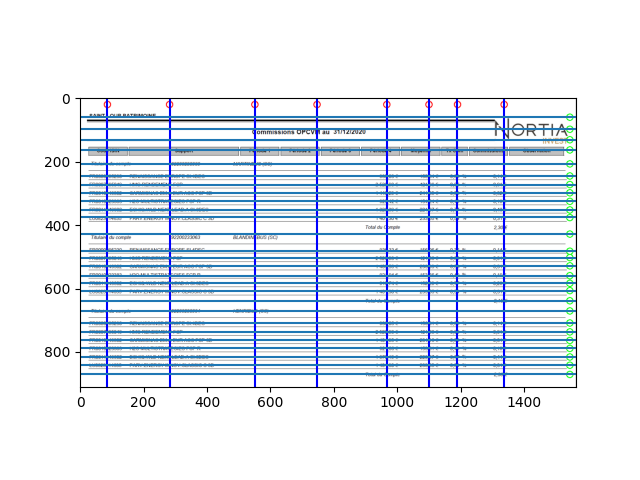

In [148]:
%matplotlib 
import cv2
from matplotlib import pyplot as plt
image = cv2.imread(img) 
for x in xs: 
    cv2.circle(image, (round(x), 20), 10, (0,0,255), 2)
     
    plt.vlines(x, 0, 1000, colors='blue', linestyles='solid', label='', data=None)

x = len(image[0])-20
for y in ys: 
    cv2.circle(image, (x, round(y)), 10, (0,255,0), 2)
    
    plt.hlines(y, 0, 2000, colors=None, linestyles='solid', label='', data=None, )
#plt.savefig("test.png", format="png")    
plt.imshow(mmcv.bgr2rgb(image))
#cv2.imwrite('demo/out.png', mmcv.bgr2rgb(image))


In [145]:
#print(results)    

In [146]:
for idx, i in enumerate(results):
    print(f"({xPred[idx]}, {yPred[idx]}) => {i['text']}")

(1, 26) => ‘SAINT LOUP PATRIMOINE

(2, 7) => NNORTIA

(7, 7) => Commissions OPCVM au 31/12/2020

(2, 25) => INVEST

(1, 3) => Code ISIN

(7, 3) => Période 2?

(7, 3) => Période ‘

(0, 3) => Movenne

(5, 3) => Tx Com

(4, 3) => Support

(3, 3) => Période

(2, 3) => Commissions

(2, 3) => Observatior

(1, 14) => Titulaire du compte

(4, 14) => 92200233060

(3, 14) => MARTINBUS (SC)

(1, 6) => FRO000295230

(4, 6) => RENAISSANCE EUROPE SI.4DEC

(6, 6) => 935.03 €

(0, 6) => 155.84 €

(5, 6) => 036 %

(2, 6) => 0.14€

(1, 20) => FRO007495049

(4, 20) => HMG RENDEMENT FCP

(6, 20) => > 5990 90R €

(0, 20) => 421,66 €

(5, 20) => O86 %

(2, 20) => og91€

(1, 15) => FROO10149302

(4, 15) => CARMIGNAC EM.A EUR ACC FCP 3D

(6, 15) => 1449.29 €

(0, 15) => 241.55€

(5, 15) => 053 %

(2, 15) => 032¢€

(1, 0) => FRO0010923383

(4, 0) => H20 MULTISTRATEGIES FCP R

(6, 0) => 995 49 €

(0, 0) => 154 24 €

(5, 0) => 049 %

(2, 0) => o019€

(1, 16) => FROO11449602

(4, 16) => ECHIQ.WLD NEXT LEAD.A SI3D

In [147]:
import pandas as pd
array = [['' for _ in range(xClusters)] for _ in range(yClusters)] 
for idx, i in enumerate(results):
    array[yPred[idx]][xPred[idx]] = "".join(list(i['text']))

pd.DataFrame(array).to_csv("test.csv")